# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [172]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
import tools as lm 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data 

In [173]:
dat = pd.read_csv('data/growth.csv')
lbldf = pd.read_csv('data/labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary

# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 86 columns (variables).


# Descriptive plots

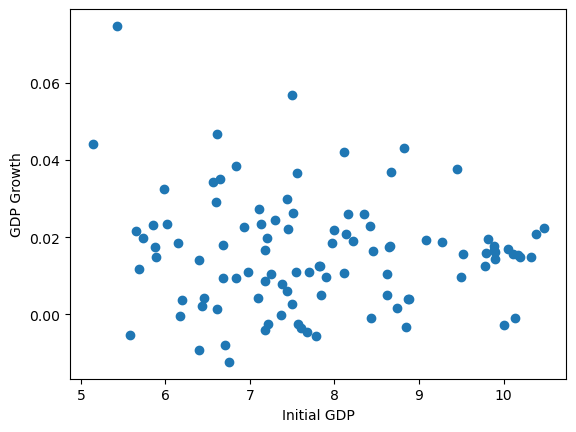

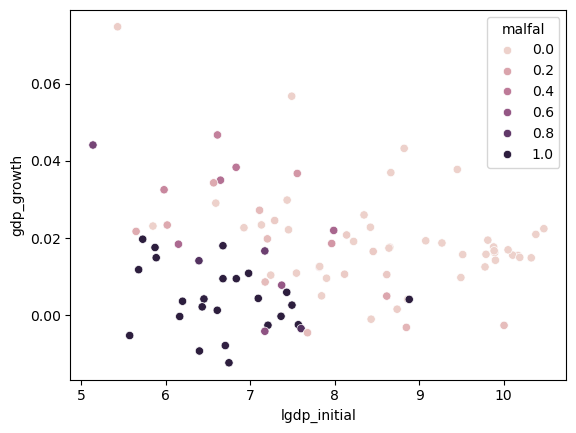

In [174]:
# Scatter plot of GDP growth against initial GDP
fig, ax = plt.subplots()
ax.scatter(dat['lgdp_initial'], dat['gdp_growth'])
ax.set_xlabel('Initial GDP')
ax.set_ylabel('GDP Growth')
plt.show()

# Accounting for the something
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [175]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ,
         }

list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


# Simple OLS

In [176]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [177]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


In [178]:
# xLabels = 
# [col for col in vv_all['all'] if 'invest' in col]

mustCols = ['ls_bl','lh_bl','lp_bl','investment_rate','gdp_growth', 'lgdp_initial']

# remove rows with missing values of lgdp_initial and gdp_growth
data = dat.dropna(subset=mustCols)

# if no democracy data, set to 0
data.loc[data[['dem','demCGV','demBMR']].isna().any(axis=1), ['dem','demCGV','demBMR']] = 0

preN = data.shape[0]
data

,code,marketref,dem,demCGV,demBMR,demreg,lp_bl,ls_bl,lh_bl,tropicar,distcr,distc,distr,ginv,polity,polity2,landlock,yellow,oilres,goldm,iron,silv,zinc,mortality,imputedmort,logem4,excolony,lt100km,democ1,democ00a,cons00a,currentinst,imr95,leb95,malfal,uvdamage,suitavg,pdiv,pdiv_aa,pdivhmi,pdivhmi_aa,pd1,pd1000,pd1500,pd1500.1,pop1,pop1000,pop1500,legor_uk,legor_fr,temp,elevavg,elevstd,kgatr,precip,suitgini,area,abslat,cenlong,area_ar,rough,ln_yst,ln_yst_aa,africa,europe,asia,oceania,americas,pprotest,pcatholic,pmuslim,pother,population_initial,population_now,gdp_pc_initial,gdp_pc_now,capital_growth_pct_gdp_initial,capital_growth_pct_gdp_now,gdp_initial,gdp_now,investment_rate,gdp_growth,pop_growth,lgdp_initial,lpop_initial,constant
4,ARG,34.144062,0.0,0.0,0.0,0.071429,72.400000,15.300000,4.000000,0.027089,271.6420,388.4080,832.6920,24.440096,-9.0,-9.0,0.0,0.0,46900.0,0.0,0.0,0.0,0.0,68.90,68.90,4.232656,1.0,0.123089,1.0,3.0,3.0,124.0,21.8,72.89,0.000000,170.535580,0.40000,0.573251,0.724738,0.566107,0.710195,0.036540,0.073081,0.103032,0.103032,9.999999e+04,2.000000e+05,2.819673e+05,0.0,1.0,13.966665,0.715286,1.002649,0.000046,52.905045,0.50347,2736690.0,34.000000,-64.000000,2.780477e+05,0.178005,8.242756,8.892195,0.0,0.0,0.0,0.0,1.0,2.7,91.6,0.20,5.50,23880564.0,4.537676e+07,7084.180589,8692.708046,24.440095,13.776598,1.691742e+11,3.944470e+11,19.976606,0.004101,0.012921,8.865619,16.988575,1.0
7,AUS,29.444778,1.0,1.0,1.0,0.954545,29.300000,48.300000,21.500000,0.381887,354.8870,354.7770,5188.9000,32.813263,10.0,10.0,0.0,1.0,99100.0,3.0,16.0,9.0,12.0,8.55,8.55,2.145931,1.0,0.198958,10.0,10.0,7.0,10.0,5.6,78.25,0.000000,223.122340,0.19000,0.644054,0.725479,NaN,NaN,0.026034,0.026034,0.026034,0.026034,2.000000e+05,2.000000e+05,2.000000e+05,1.0,0.0,21.334566,0.263313,0.186508,0.079323,45.187477,0.60792,7682300.0,27.000000,135.000000,5.031907e+05,0.053395,5.991465,8.678531,0.0,0.0,0.0,1.0,0.0,23.5,29.6,0.20,46.70,12507000.0,2.568704e+07,26120.621073,56307.280685,33.022170,22.255543,3.266906e+11,1.446367e+12,27.672347,0.015481,0.014498,10.170480,16.341799,1.0
8,AUT,38.210518,1.0,1.0,1.0,0.954545,57.263283,35.800000,2.600000,0.000000,79.4891,263.1470,81.3668,29.408796,10.0,10.0,1.0,0.0,11900.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,29.0,NaN,NaN,0.000000,87.996400,0.41000,0.736717,0.736898,0.725315,0.725698,6.064281,8.489994,24.257126,24.257126,5.000000e+05,7.000000e+05,2.000000e+06,0.0,0.0,6.847278,0.830881,0.484922,0.000000,82.061840,0.42311,82450.0,47.333332,13.333333,1.399176e+04,0.263011,8.779557,8.791410,0.0,1.0,0.0,0.0,0.0,6.5,88.8,0.60,4.10,7467086.0,8.917205e+06,19573.867162,47008.710433,31.038141,25.193306,1.461597e+11,4.191863e+11,25.954993,0.017677,0.003556,9.881951,15.826015,1.0
10,BDI,NaN,0.0,0.0,0.0,0.032258,11.365340,0.912563,0.141201,1.000000,1009.6600,1009.6600,1860.0400,4.530795,-7.0,-7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,280.00,5.634789,NaN,NaN,3.0,0.0,1.0,159.0,NaN,NaN,1.000000,272.067500,0.46000,0.761273,0.761294,0.763044,0.763075,NaN,11.916584,24.826216,24.826216,NaN,3.060179e+05,6.375372e+05,0.0,1.0,20.730478,1.406088,0.227615,0.968972,99.465900,0.20359,25680.0,3.500000,30.000000,9.599185e+03,0.255560,8.160519,8.155936,1.0,0.0,0.0,0.0,0.0,4.9,78.3,0.90,15.90,3479070.0,1.189078e+07,263.644253,202.372052,4.530795,11.377847,9.172368e+08,2.406362e+09,10.887358,-0.005276,0.024885,5.574601,15.062276,1.0
11,BEL,53.843560,1.0,1.0,1.0,0.954545,65.299510,28.700000,5.200000,0.000000,38.3926,123.7560,53.2518,28.149338,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,33.0,NaN,NaN,0.000000,70.608480,0.46000,0.729874,0.730065,0.716138,0.716497,8.469791,11.293055,35.290794,35.290794,2.560418e+05,3.413890e+05,1.066841e+06,0.0,1.0,9.525276,0.127280,0.129175,0.000000,70.291030,0.28729,30230.0,50.833332,4.000000,8.041180e+03,0.043243,8.612503,8.619641,0.0,1.0,0.0,0.0,0.0,0.4,90.0,1.10,8.50,9655549.0,1.155600e+07,19807.725392,44361.248365,29.656689,24.764056,1.912545e+11,5.126385e+11,23.671420,0.016257,0.00

### 

In [179]:
containing_all = mustCols[:]
for col in dat.columns:
    if col in ['code','europe','pother','pd1500.1','constant'] + mustCols + [col for col in dat.columns if col.startswith('gdp')]:
        continue
    if data[[col]].notnull().sum()[0]==preN:
        containing_all.append(col)


df = data[containing_all]
df = df.dropna(how='any')

# Define the number of samples and features
n = df.shape[0] # number of samples
p = df.shape[1] # number of features

# print the shape of the data 
print(f'Data contains {n} rows and {p} columns')


Data contains 86 rows and 37 columns


### Prepare data for analysis
Standardize the data.

In [180]:
# Define the labels 
Z_labels = [col for col in containing_all if col not in ['gdp_growth', 'lgdp_initial']]
Y_label = 'gdp_growth'
d_label = 'lgdp_initial'

# Define the data 
Z = df[Z_labels].values
y = df[Y_label].values
d = df[d_label].values

# Construct X as a matrix with d as the first column and Z as the rest
X = np.column_stack((d,Z))

def standardize(X):
    """function for standardizing the data"""
    return (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)

# Standardize data
X_stan = standardize(X)
Z_stan = standardize(Z)
d_stan = standardize(d)


### Post Double lasso
$$
g_i = \beta y_{i0} + \boldsymbol{z}_i \boldsymbol{\gamma} + u_i
$$
Step 1: Lasso $Z$ on $y_0$ to obtain $\widehat{\psi}$ --- $y_0 = \boldsymbol{\psi} \boldsymbol{z} + \nu$
Step 2: Lasso $Z$ on $y_0$ to obtain $\widehat{\psi}$ --- $y_0 = \boldsymbol{\psi} \boldsymbol{z} + \nu$


Step 1: Lasso Y using D and Z

---

Step 0: Create a function that calculates the BRT 

In [181]:
from scipy.stats import norm
from sklearn.linear_model import Lasso

def BRT(X_tilde,y):
    """ 
    Calculate the BRT penalty 
        Args:
            X_tilde: standardized features
            y: standardized target variable
    """
    (N,p) = X_tilde.shape
    sigma = np.std(y, ddof=1)
    c=1.1
    alpha=0.05

    penalty_BRT= (sigma*c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p))

    return penalty_BRT

def BCCH(X_tilde, y, alpha=0.05, c=1.1):
    """ 
    """
    n = len(y)
    p = len(X_tilde[0])
    penalty_term_obj = lm.penalty_term(X=X_tilde, y=y, alpha=0.05, c=1.1, n=n, p=p)
    p_lambda = penalty_term_obj.bcch_pilot_rule()
    beta_pilot = Lasso(p_lambda, fit_intercept=True).fit(X=X_tilde, y=y ).coef_
    residuals = y - X_tilde @ beta_pilot
    bcch_lambda = penalty_term_obj.bcch_rule(residuals=residuals)
    return bcch_lambda


Step 1: Lasso $g$ using $y_0$ and $z$

In [182]:
# Calculate BRT
penalty_BRTyx = BRT(X_tilde=X_stan,y=y, )
penalty_BRTyx_ = BCCH(X_tilde=X_stan,y=y, )
print(f"lambda_BRT = {penalty_BRTyx:2.4f}")
print(f"lambda_BCCH = {penalty_BRTyx_:2.4f}")

# Run Lasso 
fit_BRTyx = Lasso(penalty_BRTyx, max_iter=10_000, fit_intercept=True).fit(X_stan, y)
coefs=fit_BRTyx.coef_

# Calculate residuals
resyx = y-fit_BRTyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
resyxz = resyx + d_stan*coefs[0]

# Display first coefficient
print(f"First coefficient = {coefs[0]:.8f}",)

lambda_BRT = 0.0055
lambda_BCCH = 0.0469
First coefficient = -0.00000000


In [183]:
coefs

array([-0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.00067545, -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.00090799,  0.        , -0.        ,
        0.        ])

Step 2: Lasso $y_{0}$ using $Z$

In [184]:
# Calculate BRT
penalty_BRTdz = BRT(Z_stan, d)

# Run Lasso
fit_BRTdz = Lasso(penalty_BRTdz, max_iter=10000,fit_intercept=True).fit(Z_stan, d)
coefs=fit_BRTdz.coef_

# Calculate residuals
resdz=d-fit_BRTdz.predict(Z_stan)

# Display first coefficient
print(f"First coefficient = {coefs[0]:.8f}",)

First coefficient = 0.08224087


In [185]:
coefs

array([ 0.08224087,  0.10021007,  0.04417316,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.35987575, -0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ])

Step 3: Estimate alpha

In [186]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@d
beta_PDL = num/denom

# Display alpha
print(f"beta_PDL = {beta_PDL:.8f}",)


beta_PDL = -0.00296457


Calculate the implied variance estimate, $\check{\sigma}^2$, and calculate the standard deviation of $\check{\beta}$.

In [187]:
N = len(y)
# Calculate variance    
num = resdz**2@resyx**2/N
denom = (resdz.T@resdz/N)**2
sigma2_PDL = num/denom

# Display variance
print(f"sigma2_PDL = {sigma2_PDL:.4f}")

# Calculate standard error
se_PDL = np.sqrt(sigma2_PDL/N)

# Display standard error
print(f"se_PDL = {se_PDL:.4f}",)

# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = beta_PDL - q * se_PDL
CI_high_PDL = beta_PDL + q * se_PDL

# Display confidence interval
print(f"CI_PDL = ({CI_low_PDL:.4f}, {CI_high_PDL:.4f})")

sigma2_PDL = 0.0003
se_PDL = 0.0020
CI_PDL = (-0.0068, 0.0009)


In [188]:
np.linalg.inv(d.reshape(-1,1).T@d.reshape(-1,1)) @ d.reshape(-1,1).T @ y

# d_.reshape(-1,1).shape

array([0.00195612])

In [189]:
d_ = np.column_stack((np.ones(N), d))
np.linalg.inv(d_.T@d_) @ d_.T @ y

# d_.reshape(-1,1).shape

array([ 0.02753225, -0.00145907])

## Selection of variables

In [190]:
# remove rows with missing values of lgdp_initial and gdp_growth
df = dat.loc[(dat['lgdp_initial'].notna())&(dat['gdp_growth'].notna())]

# if no democracy data, set to 0
df.loc[df[['dem','demCGV','demBMR']].isna().any(axis=1), ['dem','demCGV','demBMR']] = 0

df.head(10) 

,code,marketref,dem,demCGV,demBMR,demreg,lp_bl,ls_bl,lh_bl,tropicar,distcr,distc,distr,ginv,polity,polity2,landlock,yellow,oilres,goldm,iron,silv,zinc,mortality,imputedmort,logem4,excolony,lt100km,democ1,democ00a,cons00a,currentinst,imr95,leb95,malfal,uvdamage,suitavg,pdiv,pdiv_aa,pdivhmi,pdivhmi_aa,pd1,pd1000,pd1500,pd1500.1,pop1,pop1000,pop1500,legor_uk,legor_fr,temp,elevavg,elevstd,kgatr,precip,suitgini,area,abslat,cenlong,area_ar,rough,ln_yst,ln_yst_aa,africa,europe,asia,oceania,americas,pprotest,pcatholic,pmuslim,pother,population_initial,population_now,gdp_pc_initial,gdp_pc_now,capital_growth_pct_gdp_initial,capital_growth_pct_gdp_now,gdp_initial,gdp_now,investment_rate,gdp_growth,pop_growth,lgdp_initial,lpop_initial,constant
4,ARG,34.144062,0.0,0.0,0.0,0.071429,72.400000,15.300000,4.000000,0.027089,271.6420,388.4080,832.6920,24.440096,-9.0,-9.0,0.0,0.0,46900.0,0.0,0.0,0.0,0.0,68.90,68.90,4.232656,1.0,0.123089,1.0,3.0,3.0,124.0,21.8,72.89,0.000000,170.53558,0.40,0.573251,0.724738,0.566107,0.710195,0.036540,0.073081,0.103032,0.103032,9.999999e+04,199999.980,281967.30,0.0,1.0,13.966665,0.715286,1.002649,0.000046,52.905045,0.50347,2736690.0,34.000000,-64.000000,278047.700,0.178005,8.242756,8.892195,0.0,0.0,0.0,0.0,1.0,2.7,91.6,0.2,5.5,23880564.0,45376763.0,7084.180589,8692.708046,24.440095,13.776598,1.691742e+11,3.944470e+11,19.976606,0.004101,0.012921,8.865619,16.988575,1.0
7,AUS,29.444778,1.0,1.0,1.0,0.954545,29.300000,48.300000,21.500000,0.381887,354.8870,354.7770,5188.9000,32.813263,10.0,10.0,0.0,1.0,99100.0,3.0,16.0,9.0,12.0,8.55,8.55,2.145931,1.0,0.198958,10.0,10.0,7.0,10.0,5.6,78.25,0.000000,223.12234,0.19,0.644054,0.725479,NaN,NaN,0.026034,0.026034,0.026034,0.026034,2.000000e+05,200000.000,200000.00,1.0,0.0,21.334566,0.263313,0.186508,0.079323,45.187477,0.60792,7682300.0,27.000000,135.000000,503190.660,0.053395,5.991465,8.678531,0.0,0.0,0.0,1.0,0.0,23.5,29.6,0.2,46.7,12507000.0,25687041.0,26120.621073,56307.280685,33.022170,22.255543,3.266906e+11,1.446367e+12,27.672347,0.015481,0.014498,10.170480,16.341799,1.0
8,AUT,38.210518,1.0,1.0,1.0,0.954545,57.263283,35.800000,2.600000,0.000000,79.4891,263.1470,81.3668,29.408796,10.0,10.0,1.0,0.0,11900.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,29.0,NaN,NaN,0.000000,87.99640,0.41,0.736717,0.736898,0.725315,0.725698,6.064281,8.489994,24.257126,24.257126,5.000000e+05,700000.000,2000000.00,0.0,0.0,6.847278,0.830881,0.484922,0.000000,82.061840,0.42311,82450.0,47.333332,13.333333,13991.765,0.263011,8.779557,8.791410,0.0,1.0,0.0,0.0,0.0,6.5,88.8,0.6,4.1,7467086.0,8917205.0,19573.867162,47008.710433,31.038141,25.193306,1.461597e+11,4.191863e+11,25.954993,0.017677,0.003556,9.881951,15.826015,1.0
10,BDI,NaN,0.0,0.0,0.0,0.032258,11.365340,0.912563,0.141201,1.000000,1009.6600,1009.6600,1860.0400,4.530795,-7.0,-7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,280.00,5.634789,NaN,NaN,3.0,0.0,1.0,159.0,NaN,NaN,1.000000,272.06750,0.46,0.761273,0.761294,0.763044,0.763075,NaN,11.916584,24.826216,24.826216,NaN,306017.880,637537.25,0.0,1.0,20.730478,1.406088,0.227615,0.968972,99.465900,0.20359,25680.0,3.500000,30.000000,9599.185,0.255560,8.160519,8.155936,1.0,0.0,0.0,0.0,0.0,4.9,78.3,0.9,15.9,3479070.0,11890781.0,263.644253,202.372052,4.530795,11.377847,9.172368e+08,2.406362e+09,10.887358,-0.005276,0.024885,5.574601,15.062276,1.0
11,BEL,53.843560,1.0,1.0,1.0,0.954545,65.299510,28.700000,5.200000,0.000000,38.3926,123.7560,53.2518,28.149338,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,33.0,NaN,NaN,0.000000,70.60848,0.46,0.729874,0.730065,0.716138,0.716497,8.469791,11.293055,35.290794,35.290794,2.560418e+05,341389.030,1066840.80,0.0,1.0,9.525276,0.127280,0.129175,0.000000,70.291030,0.28729,30230.0,50.833332,4.000000,8041.180,0.043243,8.612503,8.619641,0.0,1.0,0.0,0.0,0.0,0.4,90.0,1.1,8.5,9655549.0,11555997.0,19807.725392,44361.248365,29.656689,24.764056,1.912545e+11,5.126385e+11,23.671420,0.016257,0.003600,9.893827,16.083043,1.0
12,BEN,4.545453,0.0,0.0,0.0,0.032258,8.305782,2.140

In [191]:
# get the maximum number of data
max_of_obs = df.shape[0]

# 
var_has_no_obs = {}
for var in [col for col in df.columns if col not in ['code','lgdp_initial','gdp_growth']]:
    no_of_obs = df[var].notna().sum()
    var_has_no_obs[var] = no_of_obs

# sort the dictionary by the number of observations
sorted_var_has_no_obs = dict(sorted(var_has_no_obs.items(), key=lambda item: item[1], reverse=True))

# count how many variables have max_of_obs observations
count = 0
for key, value in sorted_var_has_no_obs.items():
    if value == max_of_obs:
        count += 1

print(f'There are {count} variables that have {max_of_obs} observations.')


There are 27 variables that have 102 observations.


In [192]:
important_cols = ['uvdamage', 'pdiv', 'legor_uk', 'legor_fr', 'area', 'cenlong', 'africa', 'europe', 'asia', 'oceania', 'americas', 'pprotest', 'pcatholic', 'pmuslim', 'pother', 'population_initial', 'population_now', 'gdp_pc_initial', 'gdp_pc_now', 'gdp_initial', 'gdp_now', 'pop_growth', 'lpop_initial', 'constant', 'temp', 'elevavg', 'precip', 'abslat', 'rough', 'demreg', 'investment_rate', 'oilres', 'goldm', 'dem', 'demCGV', 'demBMR',]
len(important_cols)
df_prim_sel = df.dropna(subset=important_cols+['gdp_growth', 'lgdp_initial'])
df_prim_sel[important_cols+['gdp_growth', 'lgdp_initial']].to_pickle('data/df_prim_sel.pkl')

# df.loc[df[important_cols].isna().any(axis=1),['code','asia','africa','europe','oceania','americas']]
print(len(important_cols))
less_important_cols = ['area_ar', 'pd1500', 'pd1500.1', 'pop1500', 'landlock', 'yellow', 'iron', 'silv', 'zinc', 'currentinst', 'pdiv_aa', 'malfal', 'ln_yst', 'pd1000', 'pop1000', 'ln_yst_aa', 'kgatr', 'tropicar', 'distcr', 'distc', 'distr', 'suitavg', 'elevstd', 'suitgini', 'lp_bl', 'ls_bl', 'lh_bl', 'ginv', 'polity', 'polity2', 'pd1', 'pop1', 'capital_growth_pct_gdp_initial', 'marketref', 'pdivhmi', 'pdivhmi_aa', 'capital_growth_pct_gdp_now', 'logem4', 'cons00a', 'imputedmort', 'democ1', 'democ00a', 'excolony', 'mortality', 'lt100km', 'imr95', 'leb95',]

keep_cols = []
keep_cols_dict = {}
for col in less_important_cols:
    dont_know = df_prim_sel.loc[df_prim_sel[col].isna()].shape[0]
    keep_cols_dict[col] = dont_know
    if dont_know == 0:
        keep_cols.append(col)

# update the lists
important_cols = important_cols + keep_cols
less_important_cols = [col for col in less_important_cols if col not in keep_cols]

print(len(important_cols))

36
44


In [193]:
# sort the dictionary by the number of observations
keep_cols_dict = dict(sorted(keep_cols_dict.items(), key=lambda item: item[1], reverse=False))
keep_cols_dict

{'pd1500': 0,
 'pd1500.1': 0,
 'pop1500': 0,
 'landlock': 0,
 'yellow': 0,
 'iron': 0,
 'silv': 0,
 'zinc': 0,
 'area_ar': 1,
 'currentinst': 1,
 'pdiv_aa': 2,
 'ln_yst': 2,
 'malfal': 3,
 'ln_yst_aa': 3,
 'kgatr': 3,
 'tropicar': 3,
 'distcr': 3,
 'distc': 3,
 'distr': 3,
 'pd1000': 4,
 'pop1000': 4,
 'suitavg': 4,
 'elevstd': 4,
 'suitgini': 4,
 'lp_bl': 8,
 'ls_bl': 8,
 'lh_bl': 8,
 'ginv': 9,
 'polity': 10,
 'polity2': 10,
 'capital_growth_pct_gdp_initial': 12,
 'marketref': 12,
 'pd1': 13,
 'pop1': 13,
 'pdivhmi': 17,
 'pdivhmi_aa': 18,
 'capital_growth_pct_gdp_now': 20,
 'logem4': 25,
 'cons00a': 27,
 'imputedmort': 29,
 'democ1': 30,
 'democ00a': 30,
 'excolony': 41,
 'mortality': 45,
 'lt100km': 45,
 'imr95': 45,
 'leb95': 45}

In [194]:
# find all variables in keep_cols_dict that have less than cut_off missing values
previous_cut_off_cols = 0
for cut_off in list(set(keep_cols_dict.values()))[1:]:
    keep_cols_dict_cut = {k: v for k, v in keep_cols_dict.items() if v <= cut_off}
    cut_off_cols = list(keep_cols_dict_cut.keys())
    
    countries_being_removed = df_prim_sel.shape[0] - df_prim_sel.dropna(subset=cut_off_cols).shape[0]
    print(f"By setting the cut-off to {cut_off}, we would remove {countries_being_removed} countries and we include {len(cut_off_cols)} variables. KJT: {len(cut_off_cols)/countries_being_removed}") # -previous_cut_off_cols
    previous_cut_off_cols = len(cut_off_cols)

# NOTE: Assuming that there is perfect overlap in NA's, then... :

By setting the cut-off to 1, we would remove 2 countries and we include 10 variables. KJT: 5.0
By setting the cut-off to 2, we would remove 5 countries and we include 12 variables. KJT: 2.4
By setting the cut-off to 3, we would remove 6 countries and we include 19 variables. KJT: 3.1666666666666665
By setting the cut-off to 4, we would remove 10 countries and we include 24 variables. KJT: 2.4
By setting the cut-off to 8, we would remove 16 countries and we include 27 variables. KJT: 1.6875
By setting the cut-off to 9, we would remove 22 countries and we include 28 variables. KJT: 1.2727272727272727
By setting the cut-off to 10, we would remove 25 countries and we include 30 variables. KJT: 1.2
By setting the cut-off to 12, we would remove 30 countries and we include 32 variables. KJT: 1.0666666666666667
By setting the cut-off to 13, we would remove 34 countries and we include 34 variables. KJT: 1.0
By setting the cut-off to 17, we would remove 43 countries and we include 35 variables. 

In [195]:
# filter data that removes few observations and include alot of variables
chosen_cut_off = 4 # Cut-off removes 10 Obs but includes 24 variables (under assumption)
add_cols = [key for key, value in keep_cols_dict.items() if value <= chosen_cut_off]
new_cols = important_cols + [col for col in add_cols if col not in important_cols]
all_cols = ['lgdp_initial','gdp_growth'] + new_cols

fil_dat = df[all_cols]
fil_dat = fil_dat[all_cols].dropna(how='any')
print(fil_dat.shape) # under assumption the number of observations should be 102-10 = 92, and is thus violated

(83, 62)


In [196]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

assert fil_dat.isna().sum().sum() == 0, "DataFrame contains NaN values"
fil_dat.to_pickle('data/selected_data.pkl')
fil_dat.head(10)

,lgdp_initial,gdp_growth,uvdamage,pdiv,legor_uk,legor_fr,area,cenlong,africa,europe,asia,oceania,americas,pprotest,pcatholic,pmuslim,pother,population_initial,population_now,gdp_pc_initial,gdp_pc_now,gdp_initial,gdp_now,pop_growth,lpop_initial,constant,temp,elevavg,precip,abslat,rough,demreg,investment_rate,oilres,goldm,dem,demCGV,demBMR,pd1500,pd1500.1,pop1500,landlock,yellow,iron,silv,zinc,area_ar,currentinst,pdiv_aa,ln_yst,malfal,ln_yst_aa,kgatr,tropicar,distcr,distc,distr,pd1000,pop1000,suitavg,elevstd,suitgini
4,8.865619,0.004101,170.53558,0.573251,0.0,1.0,2736690.0,-64.000000,0.0,0.0,0.0,0.0,1.0,2.7,91.6,0.2,5.5,23880564.0,45376763.0,7084.180589,8692.708046,1.691742e+11,3.944470e+11,0.012921,16.988575,1.0,13.966665,0.715286,52.905045,34.000000,0.178005,0.071429,19.976606,46900.0,0.0,0.0,0.0,0.0,0.103032,0.103032,281967.30,0.0,0.0,0.0,0.0,0.0,278047.700,124.0,0.724738,8.242756,0.000000,8.892195,0.000046,0.027089,271.6420,388.4080,832.6920,0.073081,199999.980,0.40,1.002649,0.50347
7,10.170480,0.015481,223.12234,0.644054,1.0,0.0,7682300.0,135.000000,0.0,0.0,0.0,1.0,0.0,23.5,29.6,0.2,46.7,12507000.0,25687041.0,26120.621073,56307.280685,3.266906e+11,1.446367e+12,0.014498,16.341799,1.0,21.334566,0.263313,45.187477,27.000000,0.053395,0.954545,27.672347,99100.0,3.0,1.0,1.0,1.0,0.026034,0.026034,200000.00,0.0,1.0,16.0,9.0,12.0,503190.660,10.0,0.725479,5.991465,0.000000,8.678531,0.079323,0.381887,354.8870,354.7770,5188.9000,0.026034,200000.000,0.19,0.186508,0.60792
8,9.881951,0.017677,87.99640,0.736717,0.0,0.0,82450.0,13.333333,0.0,1.0,0.0,0.0,0.0,6.5,88.8,0.6,4.1,7467086.0,8917205.0,19573.867162,47008.710433,1.461597e+11,4.191863e+11,0.003556,15.826015,1.0,6.847278,0.830881,82.061840,47.333332,0.263011,0.954545,25.954993,11900.0,0.0,1.0,1.0,1.0,24.257126,24.257126,2000000.00,1.0,0.0,0.0,0.0,0.0,13991.765,29.0,0.736898,8.779557,0.000000,8.791410,0.000000,0.000000,79.4891,263.1470,81.3668,8.489994,700000.000,0.41,0.484922,0.42311
10,5.574601,-0.005276,272.06750,0.761273,0.0,1.0,25680.0,30.000000,1.0,0.0,0.0,0.0,0.0,4.9,78.3,0.9,15.9,3479070.0,11890781.0,263.644253,202.372052,9.172368e+08,2.406362e+09,0.024885,15.062276,1.0,20.730478,1.406088,99.465900,3.500000,0.255560,0.032258,10.887358,0.0,0.0,0.0,0.0,0.0,24.826216,24.826216,637537.25,0.0,1.0,0.0,0.0,0.0,9599.185,159.0,0.761294,8.160519,1.000000,8.155936,0.968972,1.000000,1009.6600,1009.6600,1860.0400,11.916584,306017.880,0.46,0.227615,0.20359
11,9.893827,0.016257,70.60848,0.729874,0.0,1.0,30230.0,4.000000,0.0,1.0,0.0,0.0,0.0,0.4,90.0,1.1,8.5,9655549.0,11555997.0,19807.725392,44361.248365,1.912545e+11,5.126385e+11,0.003600,16.083043,1.0,9.525276,0.127280,70.291030,50.833332,0.043243,0.954545,23.671420,0.0,0.0,1.0,1.0,1.0,35.290794,35.290794,1066840.80,0.0,0.0,0.0,0.0,0.0,8041.180,33.0,0.730065,8.612503,0.000000,8.619641,0.000000,0.000000,38.3926,123.7560,53.2518,11.293055,341389.030,0.46,0.129175,0.28729
12,6.678539,0.009465,259.76270,0.744215,0.0,1.0,110620.0,2.250000,1.0,0.0,0.0,0.0,0.0,2.8,18.5,15.2,63.5,2912338.0,12123198.0,795.156411,1273.541317,2.315764e+09,1.543939e+10,0.028934,14.884467,1.0,27.753115,0.244412,84.799230,9.500000,0.039802,0.032258,15.784470,3930.0,0.0,0.0,0.0,0.0,4.332022,4.332022,479208.25,0.0,1.0,0.0,0.0,0.0,23805.424,175.0,0.743449,8.039157,1.000000,8.039125,0.442354,1.000000,352.1740,355.2020,617.7110,2.756741,304950.720,0.52,0.104699,0.09314
13,5.728592,0.019695,269.04742,0.741030,0.0,1.0,273600.0,-2.000000,1.0,0.0,0.0,0.0,0.0,1.6,9.0,43.0,46.4,5624592.0,20903278.0,307.535839,815.480856,1.729764e+09,1.704622e+10,0.026603,15.542659,1.0,28.639091,0.285449,66.651634,13.000000,0.031312,0.032258,17.739997,0.0,0.0,0.0,0.0,0.0,4.332022,4.332022,1185241.10,1.0,1.0,0.0,0.0,0.0,40410.723,153.0,0.741030,7.972466,1.000000,7.972466,0.117668,1.000000,731.8450,732.2480,960.3760,2.756741,754244.440,0.35,0.039076,0.25894
14,6.019042,0.023371,206.00635,0.711554,1.0,0.0,130170.0,90.000000,0.0,0.0,1.0,0.0,0.0,0.2,0.2,85.9,13.7,64232486.0,164689383.0,411.184392,1305.259332

In [197]:
# # Perform Breusch Pagan test
# # 1. extract residuals 
# y = fil_dat.gdp_growth.to_numpy().reshape(-1,1)
# x = fil_dat.lgdp_initial.to_numpy().reshape(-1,1)
# const = np.ones(len(x))
# x = np.column_stack((const,x))

# result_OLS = lm.estimate(y, x, robust=False)
# u_hat = result_OLS.get('u_hat')

# # 2. perform test
# bp_stat, p_value = lm.breusch_pagan_test(u_hat, x)
# print(p_value) # reject null with 5 pct. significance level



# Perform Breusch Pagan test
# 1. extract residuals 
y = fil_dat.gdp_growth.to_numpy().reshape(-1,1)
x = fil_dat.lgdp_initial.to_numpy().reshape(-1,1)
const = np.ones(len(x))
x = np.column_stack((const,x))

result_OLS = lm.estimate(y, x, robust=False)
u_hat = result_OLS.get('u_hat')

# 2. perform test
bp_stat, p_value = lm.breusch_pagan_test(u_hat, x)



# Perform OLS 
result_OLS = lm.estimate(y, x, robust=False)
b_hat = result_OLS.get('b_hat')
t_values = result_OLS.get('t_values')
print(f'coef of itnerest: {b_hat[1]}, with t-value {t_values[1]}')

# Perform onesided test
# 1. extract critical value 
import scipy.stats as stats

n = len(y)     
k = len(b_hat) # with intercept
df = n - k     
alpha = 0.10 # sign. level
print(n)

# Calculate the critical t-value for the one-sided test
critical_t_value = stats.t.ppf(alpha, df)

print('H0 is',t_values[1] < critical_t_value)


coef of itnerest: [-0.00085234], with t-value [-0.72949091]
83
H0 is [False]
